<a href="https://colab.research.google.com/github/helonayala/pinn/blob/main/01_DeepVIV_sec21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quick description

In this notebook we reproduce the results of the paper 

* Raissi, Maziar, Zhicheng Wang, Michael S. Triantafyllou, and George Em Karniadakis."Deep learning of vortex-induced vibrations." Journal of Fluid Mechanics 861 (2019): 119-137.

in particular Section 2.1. Please refer to the paper for a detailed description of the method and case study. In the following we restrict to the information needed for the notebook to be self-contained.

# Problem definition

In summary, we will use the Physically informed artificial neural networks (PINNs) for solving the forward and inverse problems related to the dynamics of a mass-spring-damper of the form

$$
\rho \ddot x (t) + b \dot x (t) + k x (t) = f (t)
$$

where the terms are described as follows
* $\rho, b, k$: inertia, viscous friction, and rigidity, respectively;
* $x(t)$: displacement;
* $f(t)$: sum of external forces

(please note I exchanged $\eta$ to $x$ if you compare to the notation used in the original paper)

On one hand, the forward problem relates to solving numerically the 2nd order ODE described in the EOM given. On the other hand, the inverse problems related to inferring the parameters of the system: $\rho, b,k$

# Assumptions

We work under the assumptions that
* we know the time series $[x(t),f(t)]$, and
* we know the constitutive model of the system under study (thus, PINN).

# Imports and definitions 


In [1]:
#@title
!pip install -U tensorflow-addons
!pip install -q "tqdm>=4.36.1"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# progress bar for model.fit function
import tensorflow_addons as tfa
import tqdm

# set random seed for reproduction
tf.random.set_seed(42)

# initialize tqdm callback
tqdm_callback = tfa.callbacks.TQDMProgressBar(
  leave_epoch_progress = True,
  leave_overall_progress = True,
  show_epoch_progress = False,
  show_overall_progress = True,
  )


Requirement already up-to-date: tensorflow-addons in /usr/local/lib/python3.6/dist-packages (0.11.2)


# Load data and plot

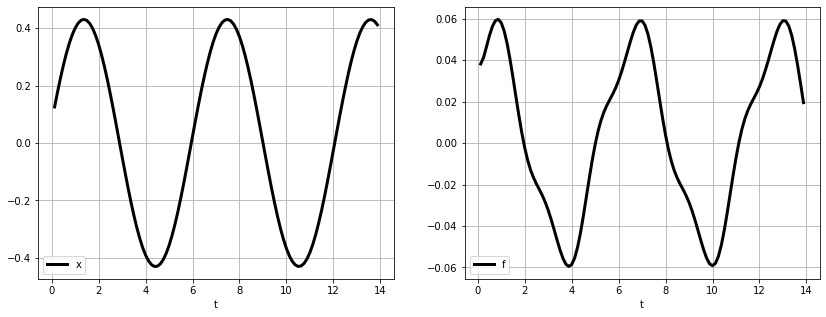

In [2]:
VIVdata = loadmat('/content/VIV_displacement_lift_drag.mat')

x = VIVdata['eta_structure']
f = VIVdata['lift_structure']
t = VIVdata['t_structure']

N_train = t.shape[0] # how much data ?

# time series plots 
plt.figure(figsize=[14,5])
plt.subplot(121)
plt.plot(t,x,'k',linewidth=3)
plt.legend('x')
plt.xlabel('t')
plt.grid()

plt.subplot(122)
plt.plot(t,f,'k',linewidth=3)
plt.legend('f')
plt.xlabel('t')
plt.grid()
plt.show()

# Layer class

Here we define the layer for 

In [3]:
class tToXandF(tf.keras.layers.Layer):
    """
    Implements two blocks: mapping time (the independent variable) to x (the state)
    """
    def __init__(self, name="tToXandF", **kwargs):
        super(tToXandF, self).__init__(name=name, **kwargs)

        self.nneu = 32
        self.actfcn = tf.sin

        self.dense1  = tf.keras.layers.Dense(self.nneu, activation=self.actfcn)
        self.dense2  = tf.keras.layers.Dense(self.nneu, activation=self.actfcn)
        self.dense3  = tf.keras.layers.Dense(self.nneu, activation=self.actfcn)
        self.dense4  = tf.keras.layers.Dense(self.nneu, activation=self.actfcn)
        self.dense5  = tf.keras.layers.Dense(self.nneu, activation=self.actfcn)
        self.dense6  = tf.keras.layers.Dense(self.nneu, activation=self.actfcn)
        self.dense7  = tf.keras.layers.Dense(self.nneu, activation=self.actfcn)
        self.dense8  = tf.keras.layers.Dense(self.nneu, activation=self.actfcn)
        self.dense9  = tf.keras.layers.Dense(self.nneu, activation=self.actfcn)
        self.dense10 = tf.keras.layers.Dense(self.nneu, activation=self.actfcn)
        self.densen  = tf.keras.layers.Dense(1)
        
        self.b = tf.Variable(0.05,name = 'b',trainable=True, dtype=tf.float32)
        self.k = tf.Variable(2.0, name = 'k',trainable=True, dtype=tf.float32)

    def call(self, t):

        # dont forget to tape the gradients
        with tf.GradientTape(persistent=True) as tape: # persistent for 2nd order derivative
          tape.watch(t)        

          # part 1: maps t to x
          x = self.dense1(t)
          x = self.dense2(x)
          x = self.dense3(x)
          x = self.dense4(x)
          x = self.dense5(x)
          x = self.dense6(x)
          x = self.dense7(x)
          x = self.dense8(x)
          x = self.dense9(x)
          x = self.dense10(x)
          x = self.densen(x)
        
          # part 2a: calculate the gradients of x wrt t
          xp  = tape.gradient(x,t) 
          xpp = tape.gradient(xp,t) 

        # part 2b: calculate the EOM
        f = 2.0 * xpp + self.b * xp + self.k * x

        return x, f # the outputs are both x and f (see assumptions)

# Model class

In [4]:
class PINN(tf.keras.Model):
    """
    Combines the 2 blocks for PINN end-to-end training
    """

    def __init__(self,name="PINN",**kwargs):
        super(PINN, self).__init__(name=name, **kwargs)

        self.tToXandF = tToXandF()

    def call(self, t):
        return self.tToXandF(t)

# Train the model

In [5]:
mdl = PINN()

lrvec = np.array([1e-3,1e-4,1e-5,1e-6])
epvec = np.array([2e3,3e3,3e3,2e3],dtype='int32')

nTrain = lrvec.shape[0]
for i in range(nTrain):
    print('Learning rate:', lrvec[i])
    mdl.compile(tf.keras.optimizers.Adam(learning_rate=lrvec[i]),loss='mse',metrics='mse')
    mdl.fit(x=t,y=[x,f], epochs=epvec[i], batch_size=N_train,verbose=0,callbacks=[tqdm_callback])

Learning rate: 0.001



Learning rate: 0.0001



Learning rate: 1e-05



Learning rate: 1e-06


# Outputs and checks

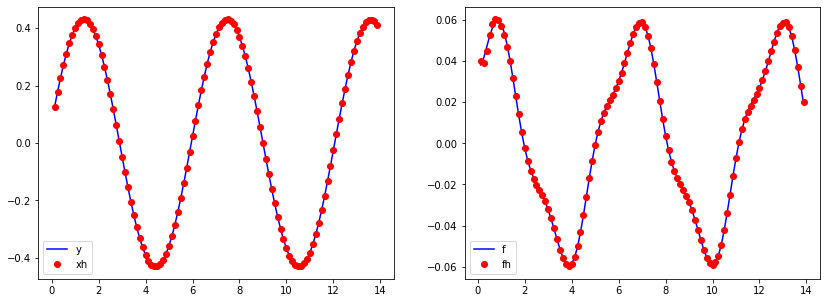

Values identified for the ODE (rho = 2.0, b = 0.084, k = 2.2020 are the real values)
<tf.Variable 'b:0' shape=() dtype=float32, numpy=0.08437444>
<tf.Variable 'k:0' shape=() dtype=float32, numpy=2.2015123>


In [6]:
xh,fh = mdl.predict(t)

plt.figure(figsize=[14,5])
plt.subplot(121)
plt.plot(t,x,'b-',t,xh,'ro')
plt.legend(['y','xh'])

plt.subplot(122)
plt.plot(t,f,'b-',t,fh,'ro')
plt.legend(['f','fh'])
plt.show()

print('Values identified for the ODE (rho = 2.0, b = 0.084, k = 2.2020 are the real values)')
print(mdl.weights[0])
print(mdl.weights[1])

In [8]:
mdl.summary()

Model: "PINN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tToXandF (tToXandF)          multiple                  9603      
Total params: 9,603
Trainable params: 9,603
Non-trainable params: 0
_________________________________________________________________
